# COMP 137 Final Project
Ethan Oliver


In [ ]:
import tensorflow as tf
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

2.4.0


In [ ]:
!pip install dd
from dd.autoref import BDD

In [ ]:
!cp /content/drive/MyDrive/deep_learning/tiny-imagenet-200.zip .

In [ ]:
!unzip /content/tiny-imagenet-200.zip

In [ ]:
#pretrained dense_model
dense_model = load_model("/content/drive/MyDrive/deep_learning/dense_post_model")

In [ ]:
#partial model to get the 1024 feature vector
partial_model = Model(dense_model.inputs, dense_model.layers[1].output)

In [ ]:
#load in data into Keras generators
from functools import partial

def get_df(labels_path):
    test_df = pd.read_csv(labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df

def load_data(batch_size, im_size):
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Training data
    training_flow_func = partial(
        image_gen.flow_from_directory, 
        directory=os.path.join('/content','tiny-imagenet-200', 'train'), 
        target_size=im_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=False)
    
    # Training data subset
    train_gen = training_flow_func(subset='training')

    # Test data from validation dataset
    test_df = get_df(os.path.join('/content','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('/content','tiny-imagenet-200',  'val', 'images'), target_size=im_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, test_gen
       
batch_size = 100
im_size = (224,224)

train_gen, test_gen = load_data(batch_size, im_size)

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


#NAP Class Definition

In [ ]:
#NAP Class Monitor
class Class_Monitor():
  def __init__(self, num_neurons, class_weights, bdd, split, varname):
    # init empty pattern set
    self.patterns = bdd.false

    self.num_neurons = num_neurons
    self.varname = varname

    # find the most influencial weights for that class
    top_indices = np.argsort(class_weights)

    # decide if selecting all positive neurons or a split of negative and positive
    if split == 0:
      self.indices = top_indices[(-num_neurons):]
    else:
      top_split = top_indices[:split]
      bottom_split = top_indices[(-(num_neurons-split)):]
      self.indices = np.concatenate((top_split, bottom_split))
      print(self.indices.shape)

  def addpattern(self, bdd,  neuron_pattern):
      selected_pattern = neuron_pattern[self.indices]

      # Generate constraint
      pattern_gen = ""
      for i in range(self.num_neurons):
        if i != 0:
          pattern_gen = pattern_gen + " & "

        if selected_pattern[i]:
          pattern_gen = pattern_gen + self.varname + str(i)
        else:
          pattern_gen = pattern_gen + "!" + self.varname + str(i)

      # Encode into bdd
      self.patterns = self.patterns | bdd.add_expr(pattern_gen)

  def ispattern(self, bdd,  neuron_pattern):
      selected_pattern = neuron_pattern[self.indices]

      # Generate constraint
      pattern_gen = ""
      for i in range(self.num_neurons):
        if i != 0:
          pattern_gen = pattern_gen + " & "

        if selected_pattern[i]:
          pattern_gen = pattern_gen + self.varname + str(i)
        else:
          pattern_gen = pattern_gen + "!" + self.varname + str(i)

      #Check if pattern is in patterns    
      if ( self.patterns & bdd.add_expr(pattern_gen)) == bdd.false :            
          return False
      else:
          return True

  def enlargeset(self, bdd):
    enlargedpatterns = self.patterns
    for i in range(self.num_neurons):
        #add a pattern with one var changed for each var
        enlargedpatterns = enlargedpatterns | bdd.exist([self.varname + str(i)], self.patterns)
    self.patterns = enlargedpatterns  

In [ ]:
#Initilizes each class selects what weights to use
def init_class_monitors(num_neurons = 100, num_classes = 50, split = 0, varname = 'p' ):
  bdd_new = BDD()
  for i in range(num_neurons):
      bdd_new.add_var(varname+str(i))

  class_monitor_list =[]
  weights = dense_model.layers[2].weights[0]

  for i in range(num_classes):
    class_weights = weights[:,i]
    c = Class_Monitor(num_neurons, class_weights, bdd_new, split = split, varname=varname)
    class_monitor_list.append(c)

  return bdd_new, class_monitor_list

In [ ]:
bdd_new, class_monitor_list = init_class_monitors()

In [ ]:
activation_len = 1024
#Trains each class on every pattern within the training set
def encode_patterns(num_classes=50, threshold = 0 ):
  train_gen.reset()
  i=0
  count = 0
  thresholds = np.full(activation_len, threshold)
  # print(train_gen.__len__())
  for x,y in train_gen:
      if i >= 300:
        break
      i+=1
      # if i %50 == 0:
      #   # print("Batches iterared: ", i)
      #   # print("Count: ",count)

      y_dat = np.argmax(y, axis=1)
      y_filt = np.where(y_dat < num_classes)
      x_filt = x[y_filt]

      #Only train patterns on the specific chosen classes
      if len(y_filt[0] > 0 ):
        x_features = partial_model([x_filt], training=False)
        prediction = dense_model.predict(x_filt)
        test_preds = np.argmax(prediction, axis=1)

        for x,y, out in zip( test_preds,y_dat[y_filt], x_features):

          #Only encode correctly predict classes 
          if x == y:
            count+=1 
            
            pattern = np.greater(out, thresholds)
            class_monitor_list[x].addpattern(bdd_new, pattern)
  print("Count: ",count)

In [ ]:
encode_patterns()

Count:  24376


In [ ]:
#Hamming distance extension function
def extend_patterns(num_classes=50):
  for i in range(num_classes):
    class_monitor_list[i].enlargeset(bdd_new)

In [ ]:
#Test function with metrics
np.set_printoptions(precision=3)

def test_class_monitors(num_classes=50, threshold = 0):
  thresholds = np.full(activation_len, threshold)
  classified_wrong = 0
  out_of_activation_wrong = 0
  out_of_activation = 0
  total =0
  i= 0

  for x,y in test_gen:
    i+=1
    if i>test_gen.__len__():
        break
    prediction = dense_model.predict(x)
    test_preds = np.argmax(prediction, axis=1)

    #Only test on predictions within the class
    x_index = np.where(test_preds < num_classes)
    if(len(x_index[0]) >0):
      x_filt = x[x_index]
      test_preds_filt = test_preds[x_index]
      y_filt = y[x_index]
      x_features = partial_model([x_filt], training=False)
      
      y_dat = np.argmax(y_filt, axis=1)

      for x,y, part in zip(test_preds_filt,y_dat, x_features):
        total+=1
        pattern = np.greater(part, thresholds)
        contained = class_monitor_list[x].ispattern( bdd_new,  pattern)
        if not contained:
          out_of_activation += 1
        if x != y: 
          classified_wrong+=1 
          if not contained:
            out_of_activation_wrong+= 1
  #Results
  print("Out_of_activation : ", out_of_activation, " Classified Wrong: " ,classified_wrong, "Classified wrong and out of activation: ", out_of_activation_wrong, "Total: ", total  )
  if(out_of_activation > 0):
    print("Accuracy: ", 1- classified_wrong/total,  " Percent Out of Activation: ", 100* out_of_activation/total, " outofAandwrong/wrong: ", 100* out_of_activation_wrong/classified_wrong, " outofAandwrong/outofA: ", 100* out_of_activation_wrong/out_of_activation)
  dictified = {"wrong": classified_wrong, "total": total , "out_act": out_of_activation, "out_act_wrong": out_of_activation_wrong  }
  return dictified

In [ ]:
res = test_class_monitors(num_classes=50)

#Hyper Parameter Searches

In [ ]:
#Large scale hyper parameter search
neuron_lengths =[100,160,200,240]
neuron_neg =[0, 5,10]
thersholdings =[0.0001, 0.0005, 0.0025, 0.005]

patternname =[]
hyper_search = []
for split in neuron_neg:
  for length in neuron_lengths:
    for threshold in thersholdings:
        name = "split_" + str(split) + "length_" + str(length) + "threshold_" + str(threshold)
        print(name)
        patternname.append(name)

        bdd_new, class_monitor_list = init_class_monitors(num_neurons =length, split= split)
        encode_patterns(threshold=threshold)
        res = test_class_monitors(num_classes=50, threshold=threshold)
        hyper_search.append(res)





split_0length_100threshold_0.0001
Count:  24376
Out_of_activation :  45  Classified Wrong:  554 Classified wrong and out of activation:  31 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  1.8307567127746136  outofAandwrong/wrong:  5.595667870036101  outofAandwrong/outofA:  68.88888888888889
split_0length_100threshold_0.0005
Count:  24376
Out_of_activation :  54  Classified Wrong:  554 Classified wrong and out of activation:  36 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  2.196908055329536  outofAandwrong/wrong:  6.498194945848375  outofAandwrong/outofA:  66.66666666666667
split_0length_100threshold_0.0025
Count:  24376
Out_of_activation :  85  Classified Wrong:  554 Classified wrong and out of activation:  52 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  3.4580960130187144  outofAandwrong/wrong:  9.386281588447654  outofAandwrong/outofA:  61.1764705882353
split_0length_100threshold_0.005
Count:  24376
Out_of_act

In [ ]:
#Hyperparameter search on neuron length
neuron_lengths =[20,40,60,80,100,120,140,160,180,200,220,240,260]
neuron_lengths_results=[]
for length in neuron_lengths:

  bdd_new, class_monitor_list = init_class_monitors(num_neurons =length)
  encode_patterns()
  res = test_class_monitors(num_classes=50)
  neuron_lengths_results.append(res)

print(neuron_lengths_results)

Count:  24376
Out_of_activation :  12  Classified Wrong:  554 Classified wrong and out of activation:  5 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  0.4882017900732303  outofAandwrong/wrong:  0.9025270758122743  outofAandwrong/outofA:  41.666666666666664
Count:  24376
Out_of_activation :  21  Classified Wrong:  554 Classified wrong and out of activation:  11 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  0.8543531326281529  outofAandwrong/wrong:  1.9855595667870036  outofAandwrong/outofA:  52.38095238095238
Count:  24376
Out_of_activation :  24  Classified Wrong:  554 Classified wrong and out of activation:  13 Total:  2458
Accuracy:  0.774613506916192  Percent Out of Activation:  0.9764035801464606  outofAandwrong/wrong:  2.3465703971119134  outofAandwrong/outofA:  54.166666666666664
Count:  24376
Out_of_activation :  34  Classified Wrong:  554 Classified wrong and out of activation:  21 Total:  2458
Accuracy:  0.774613506916192  Perc

In [ ]:
import pickle

# pickle.dump( vary_neuron, open( "/content/drive/MyDrive/deep_learning/vary_neuron.p", "wb" ) )
pickle.dump( neuron_lengths_results, open( "/content/drive/MyDrive/deep_learning/neuron_lengths_results.p", "wb" ) )

In [ ]:
#Hyperparameter search on neuron negativesplit
neuron_neg =[10,15,20, 25, 50]
neuron_neg_results=[]
for neg in neuron_neg:
  bdd_new, class_monitor_list = init_class_monitors(split=neg)
  encode_patterns()
  res = test_class_monitors(num_classes=50)
  neuron_neg_results.append(res)
  print("extending pattern")
  extend_patterns()
  res = test_class_monitors(num_classes=50)
  neuron_neg_results.append(res)

print(neuron_neg_results)

In [ ]:
pickle.dump( neuron_neg_results, open( "/content/drive/MyDrive/deep_learning/neuron_neg_results.p", "wb" ) )

In [ ]:
#Hyperparameter search on hamming
hamming =[100, 150, 200, 250]
hamming_results=[]
for ham in hamming:
  bdd_new, class_monitor_list = init_class_monitors(num_neurons=ham)
  encode_patterns()
  res = test_class_monitors(num_classes=50)
  hamming_results.append(res)
  print("extending pattern")
  extend_patterns()
  res2 = test_class_monitors(num_classes=50)
  hamming_results.append(res2)

print(hamming_results)
pickle.dump( hamming_results, open( "/content/drive/MyDrive/deep_learning/hamming_results.p", "wb" ) )

Count:  24376
Out_of_activation :  43  Classified Wrong:  554 Classified wrong and out of activation:  29 Total:  2458
extending pattern
Out_of_activation :  0  Classified Wrong:  554 Classified wrong and out of activation:  0 Total:  2458
Count:  24376
Out_of_activation :  73  Classified Wrong:  554 Classified wrong and out of activation:  42 Total:  2458
extending pattern
Out_of_activation :  3  Classified Wrong:  554 Classified wrong and out of activation:  2 Total:  2458
Count:  24376
Out_of_activation :  100  Classified Wrong:  554 Classified wrong and out of activation:  52 Total:  2458
extending pattern
Out_of_activation :  9  Classified Wrong:  554 Classified wrong and out of activation:  6 Total:  2458
Count:  24376
Out_of_activation :  141  Classified Wrong:  554 Classified wrong and out of activation:  69 Total:  2458
extending pattern
Out_of_activation :  15  Classified Wrong:  554 Classified wrong and out of activation:  10 Total:  2458
[{'wrong': 554, 'total': 2458, 'out_

In [ ]:
#Hyperparameter search on thersholding 
thersholdings =[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.05]
thersholdings_results=[]
for thersh in thersholdings:
  bdd_new, class_monitor_list = init_class_monitors()
  encode_patterns(threshold=thersh)
  res = test_class_monitors(num_classes=50, threshold=thersh)
  thersholdings_results.append(res)

print(thersholdings_results)
pickle.dump( thersholdings_results, open( "/content/drive/MyDrive/deep_learning/thersholdings_results.p", "wb" ) )

Exception ignored in: <bound method BDD.__del__ of <dd.bdd.BDD object at 0x7fda4da2fbe0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/dd/bdd.py", line 186, in __del__
    assert all(v == 0 for v in self._ref.values()), self._ref
AssertionError: {1: 169, 4952: 1, 4953: 1, 4954: 1, 4955: 1, 4956: 1, 4957: 1, 4958: 1, 4959: 1, 4960: 1, 4961: 1, 4962: 1, 4963: 1, 4964: 1, 4965: 1, 4966: 1, 4967: 1, 4968: 1, 4969: 1, 4970: 1, 4971: 1, 4972: 1, 4973: 1, 4974: 1, 4975: 1, 4976: 1, 4977: 1, 4978: 2, 4979: 1, 4980: 1, 4981: 1, 29874: 1, 45375: 1, 45376: 1, 45377: 1, 45378: 1, 45379: 1, 45380: 1, 45381: 1, 45382: 1, 45383: 1, 45384: 1, 45385: 2, 45386: 1, 45387: 1, 45388: 1, 45389: 1, 45390: 1, 45391: 1, 45392: 1, 45393: 1, 45394: 2, 45395: 1, 45396: 1, 45397: 1, 45398: 1, 45399: 1, 45400: 1, 45401: 1, 45402: 1, 45403: 1, 45404: 1, 45405: 1, 45406: 1, 45407: 1, 45408: 1, 45409: 1, 45410: 1, 45411: 1, 45412: 1, 45413: 1, 45414: 1, 45415: 1, 45416: 1, 45417: 1

Count:  24376
Out_of_activation :  45  Classified Wrong:  554 Classified wrong and out of activation:  31 Total:  2458
Count:  24376
Out_of_activation :  50  Classified Wrong:  554 Classified wrong and out of activation:  32 Total:  2458
Count:  24376
Out_of_activation :  54  Classified Wrong:  554 Classified wrong and out of activation:  36 Total:  2458
Count:  24376
Out_of_activation :  65  Classified Wrong:  554 Classified wrong and out of activation:  40 Total:  2458
Count:  24376
Out_of_activation :  85  Classified Wrong:  554 Classified wrong and out of activation:  52 Total:  2458
Count:  24376
Out_of_activation :  138  Classified Wrong:  554 Classified wrong and out of activation:  67 Total:  2458
Count:  24376
Out_of_activation :  346  Classified Wrong:  554 Classified wrong and out of activation:  141 Total:  2458
Count:  24376
Out_of_activation :  2123  Classified Wrong:  554 Classified wrong and out of activation:  506 Total:  2458
[{'wrong': 554, 'total': 2458, 'out_act': 

In [ ]:
#Hyperparameter search on thersholding 
thersholdings =[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.05]
thersholdings150_results=[]
for thersh in thersholdings:
  bdd_new, class_monitor_list = init_class_monitors(num_neurons=150)
  encode_patterns(threshold=thersh)
  res = test_class_monitors(num_classes=50, threshold=thersh)
  thersholdings150_results.append(res)

print(thersholdings150_results)
pickle.dump( thersholdings150_results, open( "/content/drive/MyDrive/deep_learning/thersholdings150_results.p", "wb" ) )

#Graphing Code (Not Important)

In [ ]:
neuron_lengths_results = pickle.load( open( "/content/drive/MyDrive/deep_learning/neuron_lengths_results.p", "rb" ) )

In [ ]:
thersholdings_results = pickle.load( open( "/content/drive/MyDrive/deep_learning/thersholdings_results.p", "rb" ) )

In [ ]:
for res in neuron_neg_results:
  print("RESULT")
  print("Trigger rate: ",100 * res["out_act"]/res["total"], end =" ")
  print("Pattern probability: ",100 * res["out_act_wrong"]/res["out_act"], end =" ")
  print("Senstivity: ",100 * res["out_act_wrong"]/res["wrong"])


RESULT
Trigger rate:  1.871440195280716 Pattern probability:  60.869565217391305 Senstivity:  5.054151624548736
RESULT
Trigger rate:  2.034174125305126 Pattern probability:  60.0 Senstivity:  5.415162454873646
RESULT
Trigger rate:  2.888527257933279 Pattern probability:  46.478873239436616 Senstivity:  5.956678700361011
RESULT
Trigger rate:  7.038242473555736 Pattern probability:  26.589595375722542 Senstivity:  8.303249097472925
RESULT
Trigger rate:  16.151342554922703 Pattern probability:  18.89168765743073 Senstivity:  13.537906137184116
RESULT
Trigger rate:  25.508543531326282 Pattern probability:  17.54385964912281 Senstivity:  19.855595667870038


In [ ]:
in_act = []
act_wrong_total = []
act_wrong = []
thersholdings =[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.05]
for neg in thersholdings_results[:-2]:
  in_act.append(100 * neg["out_act"]/neg["total"])
  act_wrong_total.append(100 * neg["out_act_wrong"]/neg["out_act"])
  act_wrong.append(100 * neg["out_act_wrong"]/neg["wrong"])

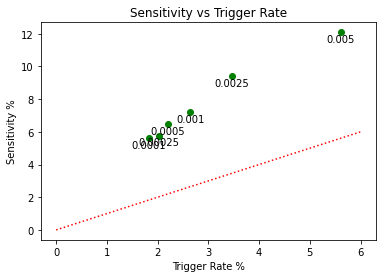

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(0,6,100)
y = x
plt.plot(x, y, ':r')
# label = ["99/1", "95/5", "90/10", "80/20"]
neuron_lengths =[20,40,60,80,100,120,140,160,180,200,220,240,260]
neuron_neg =[1, 5, 10,15,20, 25]
plt.plot(in_act, act_wrong, 'go')
plt.xlabel('Trigger Rate %')
plt.ylabel('Sensitivity %')
plt.title("Sensitivity vs Trigger Rate")

for x,y, lab in zip(in_act,act_wrong, thersholdings ):

    # label = "{:.2f}".format(y)

    plt.annotate(lab, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

['99/1', '95/5', '90/10', '80/20']


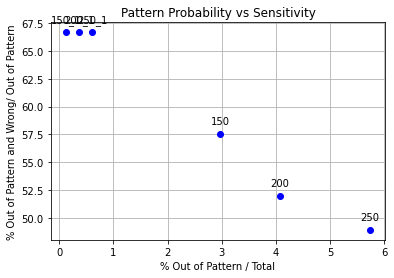

In [ ]:
# label = ["20", "40", "60", "80", "100", "120", "140", "160", "180", "200"]
neuron_lengths =[20,40,60,80,100,120,140,160,180,200,220,240,260]
# neuron_neg =[10,15,20, 25, 50]
print(label)
# x = np.linspace(0,15,100)
# y = 100 - x
# plt.plot(x, y, ':r')
plt.grid()
plt.plot(in_act, act_wrong_total, 'bo')
plt.xlabel('% Out of Pattern / Total')
plt.ylabel('% Out of Pattern and Wrong/ Out of Pattern')
plt.title("Pattern Probability vs Sensitivity")
for x,y, lab in zip(in_act,act_wrong_total, thersholdings ):

    # label = "{:.2f}".format(y)

    plt.annotate(lab, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

['99/1', '95/5', '90/10', '80/20']


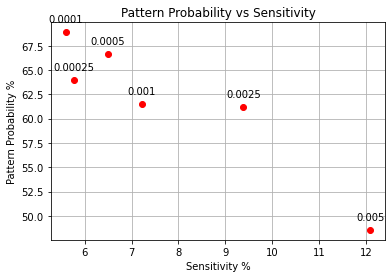

In [ ]:
# label = ["20", "40", "60", "80", "100", "120", "140", "160", "180", "200"]
neuron_lengths =[20,40,60,80,100,120,140,160,180,200,220,240,260]
print(label)
# x = np.linspace(0,15,100)
# y = 100 - x
# plt.plot(x, y, ':r')
plt.grid()
plt.plot(act_wrong, act_wrong_total, 'ro')
plt.ylabel('Pattern Probability %')
plt.xlabel('Sensitivity %')
plt.title("Pattern Probability vs Sensitivity")
for x,y, lab in zip(act_wrong,act_wrong_total, thersholdings ):

    # label = "{:.2f}".format(y)

    plt.annotate(lab, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [ ]:
np.set_printoptions(precision=3)
for p, x in zip(act_wrong_total, neuron_lengths):
  print("Portal : % 5.3f" %(p))   

Portal :  68.889
Portal :  64.000
Portal :  66.667
Portal :  61.538
Portal :  61.176
Portal :  48.551
